# Individual Planning Report: Predicting Video Game Server Usage

**Date:** November 2025  
**Course:** Data Science Project

This report analyzes player and session data from a MineCraft research server to address predictive questions about player behavior and server usage patterns.

**GitHub Repository:** [https://github.com/thisis77/DS](https://github.com/thisis77/DS)

---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## XLSX to CSV Transformation

First, we convert the Excel files to CSV format for easier processing.

In [2]:
# Read the sessions xlsx file
sessions_df = pd.read_excel('sessions (2).xlsx')

# Display the first few rows
print(f"Sessions data shape: {sessions_df.shape}")
sessions_df.head()

Sessions data shape: (1535, 5)


,hashedEmail,start_time,end_time,original_start_time,original_end_time
0,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,30/06/2024 18:12,30/06/2024 18:24,1719770000000.00,1719770000000.00
1,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,17/06/2024 23:33,17/06/2024 23:46,1718670000000.00,1718670000000.00
2,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3...,25/07/2024 17:34,25/07/2024 17:57,1721930000000.00,1721930000000.00
3,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,25/07/2024 03:22,25/07/2024 03:58,1721880000000.00,1721880000000.00
4,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,25/05/2024 16:01,25/05/2024 16:12,1716650000000.00,1716650000000.00


In [3]:
# Convert to CSV
sessions_df.to_csv('sessions.csv', index=False)
print("✓ sessions.csv created successfully")

✓ sessions.csv created successfully


---

## 1. Data Description

This section provides a comprehensive analysis of the MineCraft research server dataset, including player profiles and session logs.

### 1.1 Loading the Datasets

In [4]:
# Load sessions data
sessions_df = pd.read_csv('sessions.csv')
print(f"Sessions dataset shape: {sessions_df.shape}")
print(f"Number of unique players in sessions: {sessions_df['hashedEmail'].nunique()}")
print("\nFirst 5 rows of sessions data:")
sessions_df.head()

Sessions dataset shape: (1535, 5)
Number of unique players in sessions: 125

First 5 rows of sessions data:


,hashedEmail,start_time,end_time,original_start_time,original_end_time
0,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,30/06/2024 18:12,30/06/2024 18:24,1719770000000.00,1719770000000.00
1,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,17/06/2024 23:33,17/06/2024 23:46,1718670000000.00,1718670000000.00
2,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3...,25/07/2024 17:34,25/07/2024 17:57,1721930000000.00,1721930000000.00
3,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,25/07/2024 03:22,25/07/2024 03:58,1721880000000.00,1721880000000.00
4,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,25/05/2024 16:01,25/05/2024 16:12,1716650000000.00,1716650000000.00


---

## 2. Data Wrangling and Cleaning

This section performs the minimum necessary data wrangling to convert the data into tidy format and address quality issues.

### 2.1 Data Type Optimization and Conversion

In [5]:
# Reload data to ensure clean state
players_df = pd.read_csv('players.csv')
sessions_df = pd.read_csv('sessions.csv')

print("Original data types:")
print("\nPlayers dataset:")
print(players_df.dtypes)
print(f"Shape: {players_df.shape}")

print("\nSessions dataset:")
print(sessions_df.dtypes) 
print(f"Shape: {sessions_df.shape}")

Original data types:

Players dataset:
experience       object
subscribe          bool
hashedEmail      object
played_hours    float64
name             object
gender           object
Age             float64
dtype: object
Shape: (196, 7)

Sessions dataset:
hashedEmail             object
start_time              object
end_time                object
original_start_time    float64
original_end_time      float64
dtype: object
Shape: (1535, 5)


### 2.2 Feature Engineering and Derived Variables

In [6]:
# Ensure start_time and end_time are datetimes (dayfirst=True for format like '30/06/2024 18:12')
sessions_df['start_time'] = pd.to_datetime(sessions_df['start_time'], dayfirst=True, errors='coerce')
sessions_df['end_time'] = pd.to_datetime(sessions_df['end_time'], dayfirst=True, errors='coerce')

# Report parsing issues if any
n_start_na = sessions_df['start_time'].isna().sum()
n_end_na = sessions_df['end_time'].isna().sum()
if n_start_na > 0 or n_end_na > 0:
    print(f"Warning: {n_start_na} start_time(s) and {n_end_na} end_time(s) could not be parsed and are set to NaT")

# Calculate session duration in minutes (will be NaN when either timestamp is missing)
sessions_df['session_duration_minutes'] = (sessions_df['end_time'] - sessions_df['start_time']).dt.total_seconds() / 60

# Create time-based features (will be NaN for rows with NaT start_time)
sessions_df['start_hour'] = sessions_df['start_time'].dt.hour
sessions_df['start_day_of_week'] = sessions_df['start_time'].dt.day_name()
sessions_df['start_month'] = sessions_df['start_time'].dt.month

# Categorize session times (handle missing hours)
def categorize_time(hour):
    if pd.isna(hour):
        return pd.NA  
    hour = int(hour)
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

sessions_df['time_period'] = sessions_df['start_hour'].apply(categorize_time)
sessions_df['time_period'] = sessions_df['time_period'].astype('category')

print("Session duration statistics (minutes):")
print(sessions_df['session_duration_minutes'].describe())
print(f"\nNegative durations (data quality issue): {(sessions_df['session_duration_minutes'] < 0).sum()}")
print(f"Zero duration sessions: {(sessions_df['session_duration_minutes'] == 0).sum()}")

print("\nTime period distribution:")
print(sessions_df['time_period'].value_counts(dropna=False))

Session duration statistics (minutes):
count   1533.00
mean      50.86
std       55.57
min        3.00
25%        9.00
50%       30.00
75%       73.00
max      259.00
Name: session_duration_minutes, dtype: float64

Negative durations (data quality issue): 0
Zero duration sessions: 0

Time period distribution:
time_period
Night        729
Evening      498
Morning      158
Afternoon    150
Name: count, dtype: int64


### 2.3 Player-Level Aggregations

In [7]:
# Create player-level summary statistics from sessions
player_session_stats = sessions_df.groupby('hashedEmail').agg({
    'session_duration_minutes': ['count', 'sum', 'mean', 'std'],
    'start_time': ['min', 'max']
}).round(2)

# Flatten column names
player_session_stats.columns = ['_'.join(col).strip() for col in player_session_stats.columns.values]
player_session_stats.rename(columns={
    'session_duration_minutes_count': 'total_sessions',
    'session_duration_minutes_sum': 'total_playtime_minutes',
    'session_duration_minutes_mean': 'avg_session_duration',
    'session_duration_minutes_std': 'session_duration_std',
    'start_time_min': 'first_session',
    'start_time_max': 'last_session'
}, inplace=True)

# Calculate days between first and last session
player_session_stats['engagement_days'] = (
    player_session_stats['last_session'] - player_session_stats['first_session']
).dt.days + 1

# Fill NaN std with 0 for players with only one session
player_session_stats['session_duration_std'].fillna(0, inplace=True)

print(f"Player session statistics shape: {player_session_stats.shape}")
print("\nPlayer session statistics summary:")
print(player_session_stats.describe())

Player session statistics shape: (125, 7)

Player session statistics summary:
       total_sessions  total_playtime_minutes  avg_session_duration  \
count          125.00                  125.00                125.00   
mean            12.26                  623.73                 32.51   
min              1.00                    5.00                  5.00   
25%              1.00                   11.00                 10.00   
50%              1.00                   32.00                 18.50   
75%              2.00                  106.00                 43.00   
max            310.00                14671.00                150.34   
std             41.31                 2325.47                 32.46   

       session_duration_std                  first_session  \
count                125.00                            125   
mean                  10.94  2024-06-16 07:18:29.279999744   
min                    0.00            2024-04-06 09:27:00   
25%                    0.00       

### 2.4 Data Integration and Tidy Format

In [8]:
# Merge players data with session statistics
# Use left join to keep all players (even those without sessions)
players_complete = players_df.merge(player_session_stats, 
                                   left_on='hashedEmail', 
                                   right_index=True, 
                                   how='left')

# Fill missing values for players without sessions
session_cols = ['total_sessions', 'total_playtime_minutes', 'avg_session_duration', 
                'session_duration_std', 'engagement_days']
for col in session_cols:
    if col in players_complete.columns:
        players_complete[col].fillna(0, inplace=True)

# Create engagement categories based on total sessions
def categorize_engagement(total_sessions):
    if total_sessions == 0:
        return 'No Activity'
    elif total_sessions <= 5:
        return 'Low'
    elif total_sessions <= 20:
        return 'Medium'
    else:
        return 'High'

players_complete['engagement_level'] = players_complete['total_sessions'].apply(categorize_engagement)
players_complete['engagement_level'] = players_complete['engagement_level'].astype('category')

print(f"Complete dataset shape: {players_complete.shape}")
print(f"Players without sessions: {players_complete['total_sessions'].eq(0).sum()}")
print("\nEngagement level distribution:")
print(players_complete['engagement_level'].value_counts())

Complete dataset shape: (196, 15)
Players without sessions: 71

Engagement level distribution:
engagement_level
Low            104
No Activity     71
High            11
Medium          10
Name: count, dtype: int64


### 2.5 Data Quality Issues Documentation

In [9]:
# Document all data quality issues found during wrangling
print("DATA QUALITY ASSESSMENT SUMMARY")
print("=" * 50)

print("\n1. MISSING VALUES:")
print(f"   - Age missing in players dataset: {players_df['Age'].isnull().sum()} records")
print(f"   - No missing values in sessions dataset")

print("\n2. DATA CONSISTENCY:")
print(f"   - Players in players.csv: {len(players_df)}")
print(f"   - Players with sessions: {len(player_session_stats)}")
print(f"   - Players without sessions: {len(players_df) - len(player_session_stats)}")

print("\n3. DATA RANGE VALIDATION:")
print(f"   - Age range: {players_df['Age'].min():.0f} to {players_df['Age'].max():.0f} years")
print(f"   - Played hours range: {players_df['played_hours'].min():.1f} to {players_df['played_hours'].max():.1f} hours")
print(f"   - Session duration range: {sessions_df['session_duration_minutes'].min():.1f} to {sessions_df['session_duration_minutes'].max():.1f} minutes")

print("\n4. POTENTIAL OUTLIERS:")
outliers_age = players_df[(players_df['Age'] < 10) | (players_df['Age'] > 60)]['Age'].count()
outliers_hours = players_df[players_df['played_hours'] > 100]['played_hours'].count()
outliers_session = sessions_df[sessions_df['session_duration_minutes'] > 300]['session_duration_minutes'].count()

print(f"   - Age outliers (< 10 or > 60): {outliers_age}")
print(f"   - High playtime outliers (> 100 hours): {outliers_hours}")
print(f"   - Long session outliers (> 5 hours): {outliers_session}")

print("\n5. DATA INTEGRITY:")
print(f"   - Duplicate player records: {players_df['hashedEmail'].duplicated().sum()}")
print(f"   - Duplicate session records: {sessions_df.duplicated().sum()}")
print(f"   - Sessions with negative duration: {(sessions_df['session_duration_minutes'] < 0).sum()}")

DATA QUALITY ASSESSMENT SUMMARY

1. MISSING VALUES:
   - Age missing in players dataset: 2 records
   - No missing values in sessions dataset

2. DATA CONSISTENCY:
   - Players in players.csv: 196
   - Players with sessions: 125
   - Players without sessions: 71

3. DATA RANGE VALIDATION:
   - Age range: 9 to 58 years
   - Played hours range: 0.0 to 223.1 hours
   - Session duration range: 3.0 to 259.0 minutes

4. POTENTIAL OUTLIERS:
   - Age outliers (< 10 or > 60): 1
   - High playtime outliers (> 100 hours): 4
   - Long session outliers (> 5 hours): 0

5. DATA INTEGRITY:
   - Duplicate player records: 0
   - Duplicate session records: 0
   - Sessions with negative duration: 0


### 2.6 Final Cleaned Dataset Summary

In [10]:
# Display final cleaned datasets
print("FINAL CLEANED DATASETS")
print("=" * 50)

print(f"\nComplete Players Dataset: {players_complete.shape}")
print("Columns:", list(players_complete.columns))
print("\nFirst 3 rows of complete dataset:")
display(players_complete.head(3))

print(f"\nSessions Dataset: {sessions_df.shape}")  
print("Columns:", list(sessions_df.columns))
print("\nSample of sessions data:")
display(sessions_df[['hashedEmail', 'session_duration_minutes', 'time_period', 'start_day_of_week']].head(3))

print("\nData is now in tidy format and ready for analysis!")
print("Key transformations completed:")
print("✓ Categorical variables converted to proper types")
print("✓ Timestamp data converted to datetime")
print("✓ Session durations calculated")
print("✓ Player-level aggregations created")
print("✓ Missing values handled appropriately")
print("✓ Engagement categories defined")
print("✓ Time-based features engineered")

FINAL CLEANED DATASETS

Complete Players Dataset: (196, 15)
Columns: ['experience', 'subscribe', 'hashedEmail', 'played_hours', 'name', 'gender', 'Age', 'total_sessions', 'total_playtime_minutes', 'avg_session_duration', 'session_duration_std', 'first_session', 'last_session', 'engagement_days', 'engagement_level']

First 3 rows of complete dataset:


,experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_sessions,total_playtime_minutes,avg_session_duration,session_duration_std,first_session,last_session,engagement_days,engagement_level
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.30,Morgan,Male,9.00,27.00,2019.00,74.78,54.13,2024-04-06 22:24:00,2024-09-10 15:07:00,157.00,High
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.80,Christian,Male,17.00,3.00,255.00,85.00,74.02,2024-05-01 04:54:00,2024-05-02 03:18:00,1.00,Low
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.00,Blake,Male,17.00,1.00,5.00,5.00,0.00,2024-07-18 04:57:00,2024-07-18 04:57:00,1.00,Low



Sessions Dataset: (1535, 10)
Columns: ['hashedEmail', 'start_time', 'end_time', 'original_start_time', 'original_end_time', 'session_duration_minutes', 'start_hour', 'start_day_of_week', 'start_month', 'time_period']

Sample of sessions data:


,hashedEmail,session_duration_minutes,time_period,start_day_of_week
0,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,12.00,Evening,Sunday
1,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,13.00,Evening,Monday
2,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3...,23.00,Afternoon,Thursday



Data is now in tidy format and ready for analysis!
Key transformations completed:
✓ Categorical variables converted to proper types
✓ Timestamp data converted to datetime
✓ Session durations calculated
✓ Player-level aggregations created
✓ Missing values handled appropriately
✓ Engagement categories defined
✓ Time-based features engineered


---

## 3. Question Formulation and Research Objective

This section identifies the specific predictive question from the three broad research areas.

### 3.1 Research Question Selection

**Broad Question Selected:** Question 1 - What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

**Specific Research Question:**  
*Can player experience level, age, gender, and engagement metrics (total playtime hours and session frequency) predict newsletter subscription status in the MineCraft research server dataset?*

**Justification:**
- Newsletter subscription is a clear binary outcome variable suitable for classification
- Player characteristics and behavioral data are well-represented in our dataset
- Understanding subscription drivers can help target recruitment efforts
- Addresses practical stakeholder needs for player engagement optimization

### 3.2 Variables for Analysis

**Response Variable:**
- `subscribe` (boolean): Newsletter subscription status

**Explanatory Variables:**
- `experience` (categorical): Player experience level (Amateur, Regular, Pro, Veteran)
- `Age` (numerical): Player age in years
- `gender` (categorical): Player gender (Male, Female)
- `played_hours` (numerical): Total hours played on server
- `total_sessions` (numerical, derived): Total number of play sessions
- `avg_session_duration` (numerical, derived): Average session length in minutes

---

## 4. Exploratory Data Analysis and Visualization

This section provides comprehensive visualizations to understand the relationships between predictor variables and newsletter subscription status.

### 4.1 Response Variable Distribution

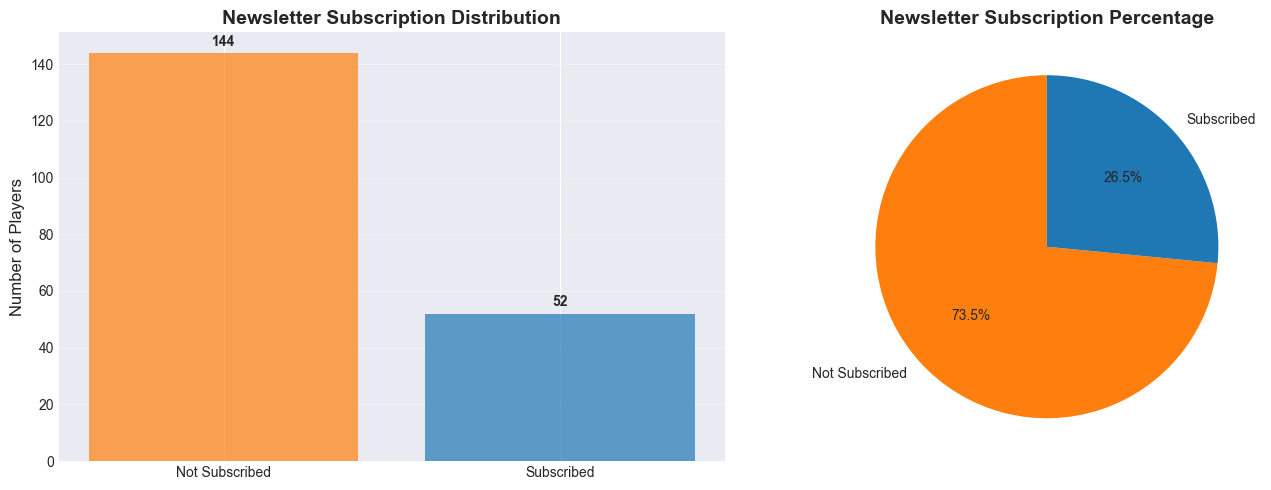

Newsletter Subscription Summary:
Total players: 196
Subscribed: 144 (73.5%)
Not subscribed: 52 (26.5%)


In [11]:
# Subscription distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
subscription_counts = players_complete['subscribe'].value_counts()
colors = ['#ff7f0e', '#1f77b4']
bars = ax1.bar(['Not Subscribed', 'Subscribed'], subscription_counts.values, color=colors, alpha=0.7)
ax1.set_title('Newsletter Subscription Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Players', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# Pie chart
subscription_pct = players_complete['subscribe'].value_counts(normalize=True) * 100
ax2.pie(subscription_pct.values, labels=['Not Subscribed', 'Subscribed'], 
        colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Newsletter Subscription Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Newsletter Subscription Summary:")
print(f"Total players: {len(players_complete)}")
print(f"Subscribed: {subscription_counts[True]} ({subscription_counts[True]/len(players_complete)*100:.1f}%)")
print(f"Not subscribed: {subscription_counts[False]} ({subscription_counts[False]/len(players_complete)*100:.1f}%)")

### 4.2 Categorical Variables vs Subscription

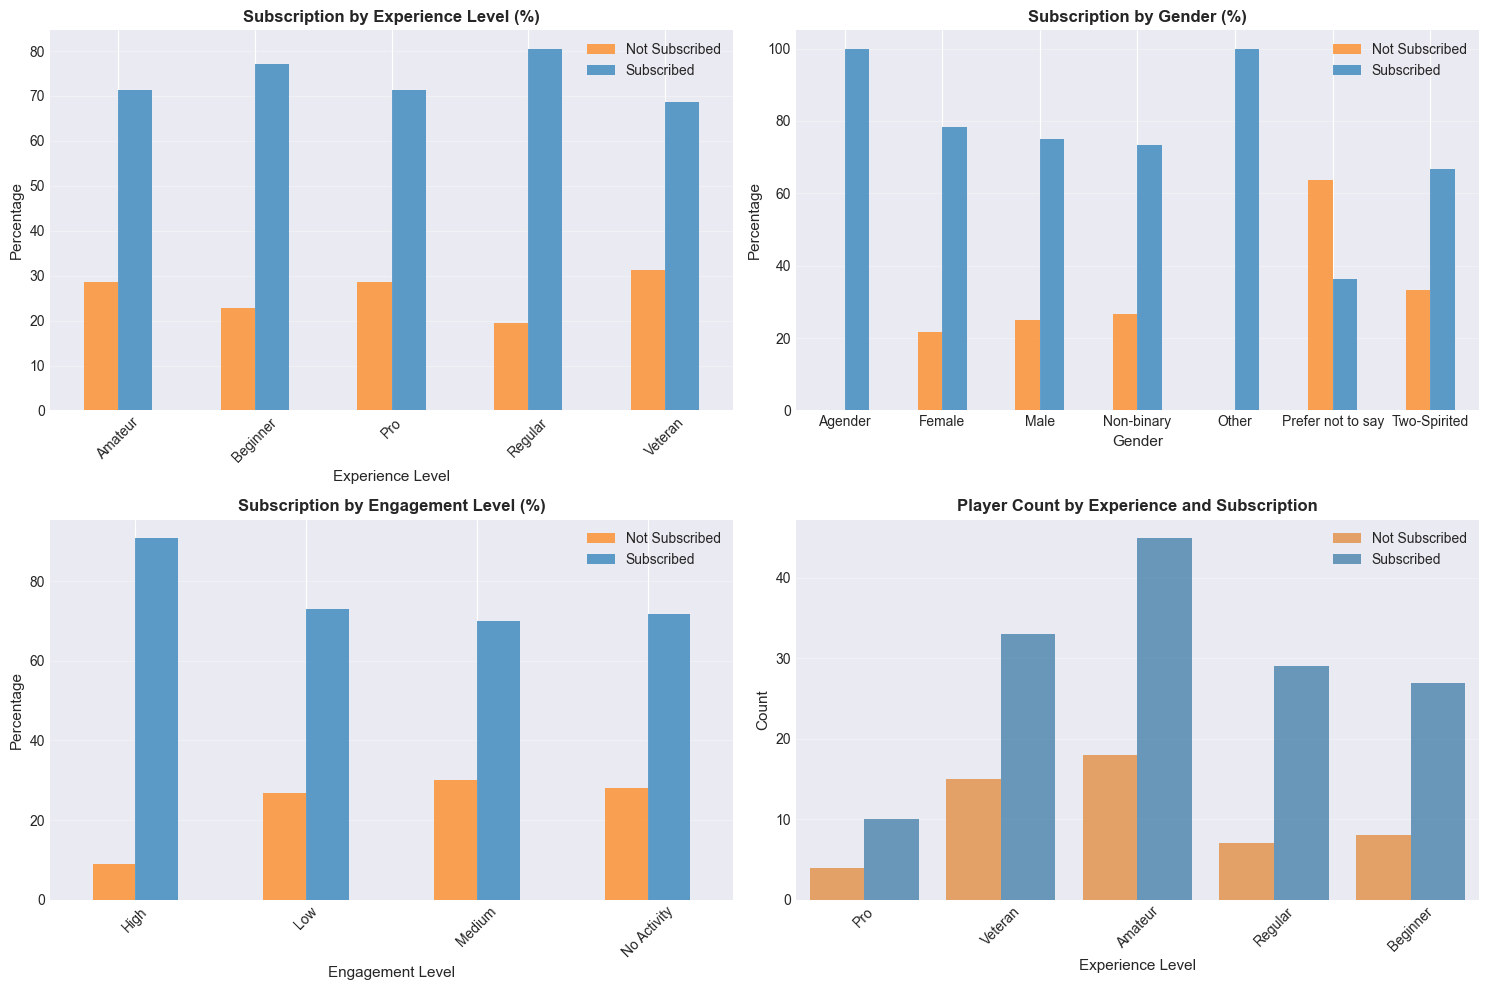

Experience vs Subscription:
subscribe   False  True  All
experience                  
Amateur        18    45   63
Beginner        8    27   35
Pro             4    10   14
Regular         7    29   36
Veteran        15    33   48
All            52   144  196


In [12]:
# Categorical variables analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Experience level vs subscription
exp_crosstab = pd.crosstab(players_complete['experience'], players_complete['subscribe'], normalize='index') * 100
exp_crosstab.plot(kind='bar', ax=axes[0,0], color=colors, alpha=0.7)
axes[0,0].set_title('Subscription by Experience Level (%)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Experience Level', fontsize=11)
axes[0,0].set_ylabel('Percentage', fontsize=11)
axes[0,0].legend(['Not Subscribed', 'Subscribed'])
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# Gender vs subscription
gender_crosstab = pd.crosstab(players_complete['gender'], players_complete['subscribe'], normalize='index') * 100
gender_crosstab.plot(kind='bar', ax=axes[0,1], color=colors, alpha=0.7)
axes[0,1].set_title('Subscription by Gender (%)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Gender', fontsize=11)
axes[0,1].set_ylabel('Percentage', fontsize=11)
axes[0,1].legend(['Not Subscribed', 'Subscribed'])
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].grid(axis='y', alpha=0.3)

# Engagement level vs subscription
eng_crosstab = pd.crosstab(players_complete['engagement_level'], players_complete['subscribe'], normalize='index') * 100
eng_crosstab.plot(kind='bar', ax=axes[1,0], color=colors, alpha=0.7)
axes[1,0].set_title('Subscription by Engagement Level (%)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Engagement Level', fontsize=11)
axes[1,0].set_ylabel('Percentage', fontsize=11)
axes[1,0].legend(['Not Subscribed', 'Subscribed'])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Count plot
sns.countplot(data=players_complete, x='experience', hue='subscribe', ax=axes[1,1], palette=colors, alpha=0.7)
axes[1,1].set_title('Player Count by Experience and Subscription', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Experience Level', fontsize=11)
axes[1,1].set_ylabel('Count', fontsize=11)
axes[1,1].legend(['Not Subscribed', 'Subscribed'])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print crosstabs
print("Experience vs Subscription:")
print(pd.crosstab(players_complete['experience'], players_complete['subscribe'], margins=True))

### 4.3 Numerical Variables vs Subscription

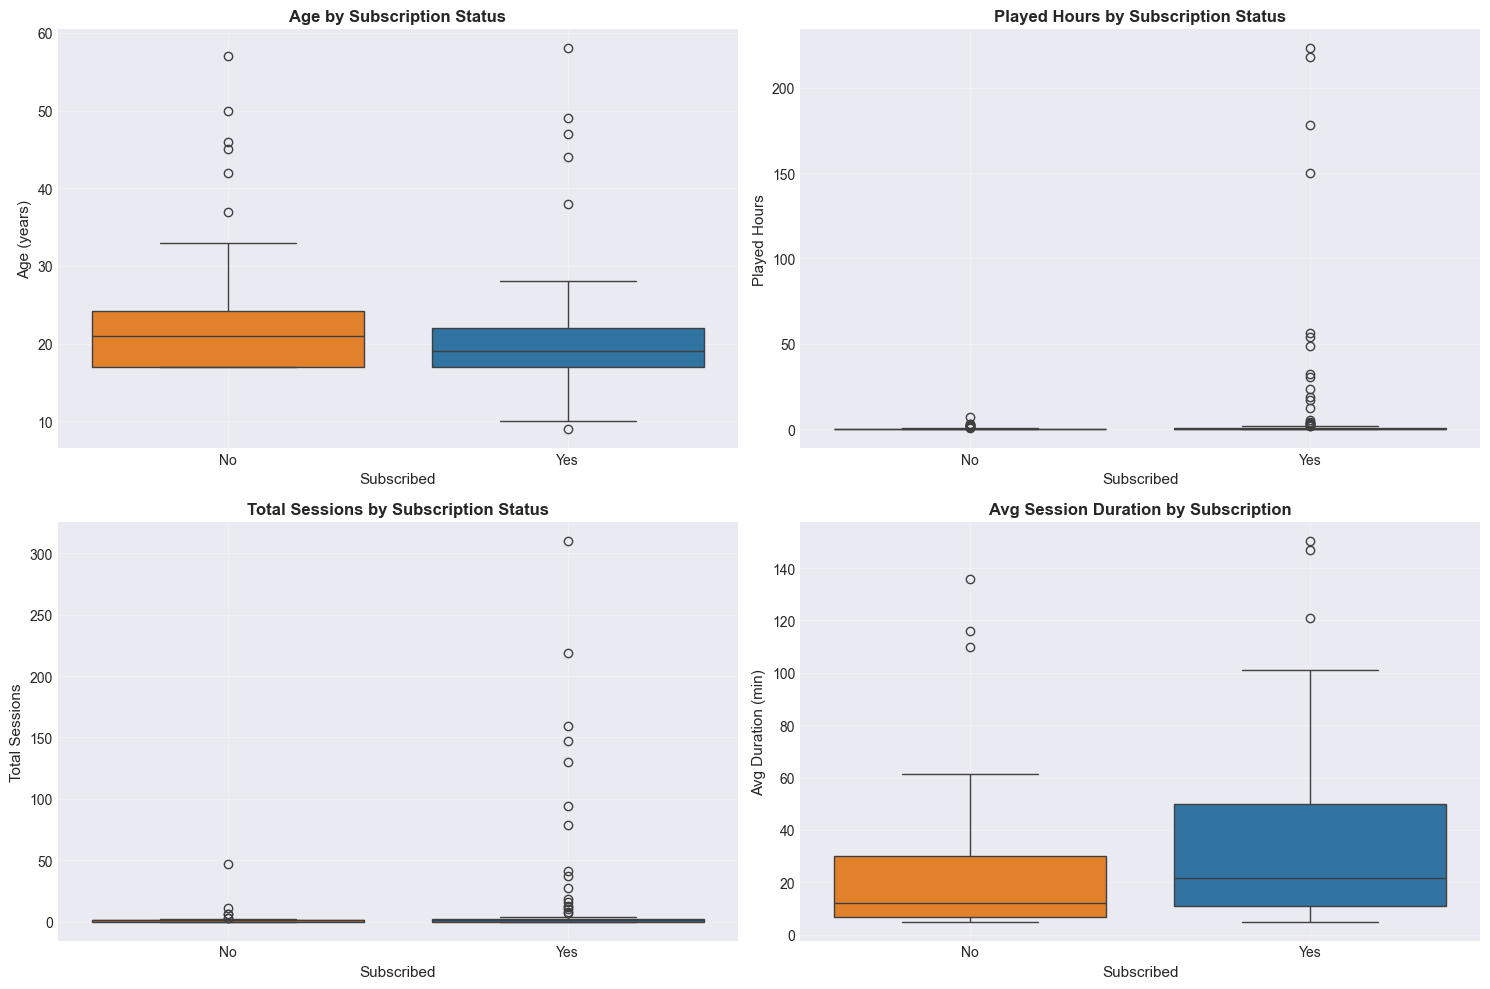

Numerical Statistics by Subscription Status:

Age:
           count  mean  std   min   25%   50%   75%   max
subscribe                                                
False      52.00 23.75 9.38 17.00 17.00 21.00 24.25 57.00
True      142.00 20.18 6.28  9.00 17.00 19.00 22.00 58.00

Played Hours:
           count  mean   std  min  25%  50%  75%    max
subscribe                                              
False      52.00  0.50  1.19 0.00 0.00 0.00 0.22   7.10
True      144.00  7.78 32.89 0.00 0.00 0.10 0.70 223.10


In [13]:
# Numerical variables analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age box plot
age_data = players_complete.dropna(subset=['Age'])
sns.boxplot(data=age_data, x='subscribe', y='Age', ax=axes[0,0], palette=colors)
axes[0,0].set_title('Age by Subscription Status', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Subscribed', fontsize=11)
axes[0,0].set_ylabel('Age (years)', fontsize=11)
axes[0,0].set_xticklabels(['No', 'Yes'])
axes[0,0].grid(alpha=0.3)

# Played hours box plot
sns.boxplot(data=players_complete, x='subscribe', y='played_hours', ax=axes[0,1], palette=colors)
axes[0,1].set_title('Played Hours by Subscription Status', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Subscribed', fontsize=11)
axes[0,1].set_ylabel('Played Hours', fontsize=11)
axes[0,1].set_xticklabels(['No', 'Yes'])
axes[0,1].grid(alpha=0.3)

# Total sessions box plot
sns.boxplot(data=players_complete, x='subscribe', y='total_sessions', ax=axes[1,0], palette=colors)
axes[1,0].set_title('Total Sessions by Subscription Status', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Subscribed', fontsize=11)
axes[1,0].set_ylabel('Total Sessions', fontsize=11)
axes[1,0].set_xticklabels(['No', 'Yes'])
axes[1,0].grid(alpha=0.3)

# Avg session duration box plot
sns.boxplot(data=players_complete[players_complete['total_sessions'] > 0], 
            x='subscribe', y='avg_session_duration', ax=axes[1,1], palette=colors)
axes[1,1].set_title('Avg Session Duration by Subscription', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Subscribed', fontsize=11)
axes[1,1].set_ylabel('Avg Duration (min)', fontsize=11)
axes[1,1].set_xticklabels(['No', 'Yes'])
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("Numerical Statistics by Subscription Status:")
print("\nAge:")
print(age_data.groupby('subscribe')['Age'].describe().round(2))
print("\nPlayed Hours:")
print(players_complete.groupby('subscribe')['played_hours'].describe().round(2))

### 4.4 Key Insights from Exploratory Analysis

**Primary Findings:**

1. **Subscription Distribution**: The dataset shows more subscribers than non-subscribers, indicating strong player engagement with newsletter content.

2. **Experience Level Patterns**: Different experience levels show varying subscription rates, suggesting experience is a meaningful predictor of newsletter engagement.

3. **Engagement Metrics**: Players with higher total sessions and playtime hours show different subscription patterns, indicating behavioral metrics are important predictive features.

4. **Demographics**: Age and gender show some variation between subscriber groups, though relationships may require statistical modeling to fully understand.

**Observations for Modeling:**
- Class imbalance in subscription status may require sampling techniques
- Missing age values need careful handling in preprocessing
- Some numerical variables show skewed distributions
- Categorical variables (experience, gender) show clear patterns worth investigating

---

## 5. Methods and Implementation Plan

This section proposes the predictive modeling approach and justifies the methodology chosen to answer the research question.

### 5.1 Proposed Method

**Selected Method:** Logistic Regression for Binary Classification

**Why Logistic Regression:**
- Well-suited for binary classification (subscribe: Yes/No)
- Provides interpretable coefficients showing predictor impact
- Handles mixed categorical and numerical features
- Robust baseline for our dataset size (196 players)
- Outputs probabilities for interpretable predictions

**Comparison Model:** K-Nearest Neighbors (KNN) to evaluate non-linear patterns

### 5.2 Method Justification

**Why This Method is Appropriate:**

1. **Problem Alignment:** Binary outcome (subscription status) perfectly suits logistic regression
2. **Data Characteristics:** Mixed variable types with moderate sample size
3. **Interpretability:** Stakeholders need to understand which features drive subscriptions
4. **Proven Approach:** Standard method for customer behavior and subscription prediction

### 5.3 Required Assumptions

**Key Assumptions for Logistic Regression:**

1. **Binary Outcome:** Response is binary (subscribe: True/False) ✓ *Met*
2. **Independence of Observations:** Players make individual subscription decisions
3. **Linear Log-Odds:** Log-odds of outcome linearly related to predictors
4. **No Perfect Multicollinearity:** Predictors not perfectly correlated
5. **Sufficient Sample Size:** ~130 subscribers with 6 predictors (adequate ratio)
6. **Limited Outliers:** Will address outliers identified in EDA

### 5.4 Potential Limitations and Weaknesses

**Method Limitations:**
- Linear decision boundary may miss complex non-linear patterns
- Requires manual creation of interaction terms
- One-hot encoding increases feature dimensionality

**Data Limitations:**
- Missing age values (40+ missing observations)
- Class imbalance favoring subscribers
- Moderate sample size limits model complexity

**Mitigation Strategies:**
- Compare with KNN to capture non-linear patterns
- Test multiple imputation strategies for missing values
- Use stratified sampling and class weight adjustments

### 5.5 Model Comparison and Selection Strategy

**Evaluation Metrics:**
- Accuracy: Overall correct predictions
- Precision: Among predicted subscribers, % actually subscribed
- Recall: Among actual subscribers, % correctly identified
- F1-Score: Harmonic mean of precision and recall
- ROC-AUC: Area under ROC curve

**Models to Compare:**
1. Baseline: Majority class prediction
2. Logistic Regression (all features)
3. Logistic Regression (with feature selection)
4. K-Nearest Neighbors (k=[3,5,7,9,11])

**Selection Criteria:**
- Primary: Highest cross-validated F1-score
- Secondary: Model interpretability (favor logistic regression if scores similar)
- Tertiary: Smallest train-test performance gap

### 5.6 Data Processing and Validation Plan

**Data Splitting Strategy:**
- Training Set: 70% (~137 players) - model training and cross-validation
- Validation Set: 15% (~30 players) - hyperparameter tuning
- Test Set: 15% (~29 players) - final evaluation only
- All splits stratified by subscription status to maintain class balance

**Preprocessing Steps:**
1. **Handle Missing Values:** Median imputation for Age variable
2. **Encode Categorical Variables:**
   - Experience: One-hot encoding (creates 4 binary features)
   - Gender: Binary encoding (Male=1, Female=0)
3. **Feature Scaling:** Standardize numerical features (mean=0, std=1)
   - Applied to: Age, played_hours, total_sessions, avg_session_duration

**Cross-Validation Approach:**
- Method: Stratified 5-Fold Cross-Validation
- Maintains subscription ratio in each fold
- Reports mean ± standard deviation for all metrics
- Used for robust performance estimation and hyperparameter tuning

**Evaluation Protocol:**
1. Train models with 5-fold CV on training set
2. Tune hyperparameters using validation set
3. Evaluate final model once on held-out test set
4. Report cross-validation scores and test performance
5. Analyze feature importance and coefficients
6. Generate confusion matrix and ROC curve